In [ ]:
import ale, json, os
import knoten.csm as csm
import ctypes
import gdal
import shapely.wkt
import numpy as np
import matplotlib.pyplot as plt

from ale.drivers.cassini_drivers import CassiniIssPds3LabelNaifSpiceDriver
from ale.drivers import JsonEncoder

In [2]:
# Use the images to generate ISDs and create CSM cameras 

# Assume images are in current directory

nac_stereo_1 = 'N1702360370_1.LBL'
nac_stereo_2 = 'N1702360308_1.LBL'

def generate_isd(filename): 
    driver = CassiniIssPds3LabelNaifSpiceDriver(filename)

    # SPICE kernels are furnished inside this with
    with driver as d:
        # this is the information for the ISD in a python dict
        aledict = d.to_dict()

    # Export python dictionary ISD to external json file to be used by CSM
    alelabel = os.path.splitext(filename)[0]+".json"
    with open (alelabel, "w") as file:
        json.dump(aledict, file, cls=JsonEncoder)
    return aledict

# Generate ISD and export to a json file
nac1_dict = generate_isd(nac_stereo_1)
nac2_dict = generate_isd(nac_stereo_2)

# Construct a camera
camera1 = csm.create_csm(nac_stereo_1)
camera2 = csm.create_csm(nac_stereo_2)

Text(0.5, 1.0, 'CSM footprints for N1702360370_1 and N1702360308_1')

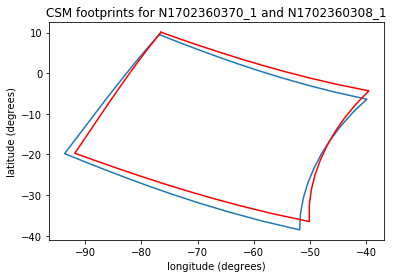

In [3]:
# ALE + CSM footprints for the two nac images 

n1lines, n1samples = nac1_dict["image_lines"], nac1_dict["image_samples"]
n2lines, n2samples = nac2_dict["image_lines"], nac2_dict["image_samples"]

boundary1 = csm.generate_boundary((n1lines, n1samples))
boundary2 = csm.generate_boundary((n2lines, n2samples))

# A different way to plot this: 
lons1, lats1, alts1 = csm.generate_latlon_boundary(camera1, boundary1, nac1_dict['radii']['semimajor'], nac1_dict['radii']['semiminor'])
lons2, lats2, alts2 = csm.generate_latlon_boundary(camera2, boundary2, nac1_dict['radii']['semimajor'], nac1_dict['radii']['semiminor'])

plt.plot(lons1, lats1)
plt.plot(lons2, lats2, 'r')
plt.xlabel("longitude (degrees)")
plt.ylabel("latitude (degrees)")
plt.title("CSM footprints for N1702360370_1 and N1702360308_1")

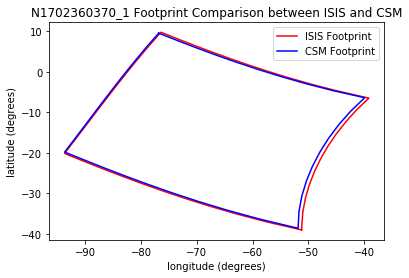

In [4]:
# "nac 1" footprint geometry comparsion between ALE+CSM and ISIS

# ALE + CSM footprint geometry
csm_footprint = csm.generate_latlon_footprint(camera1, boundary1, nac1_dict['radii']['semimajor'], nac1_dict['radii']['semiminor'])
csm_wkt = csm_footprint.ExportToWkt()
csm_geom = shapely.wkt.loads(csm_wkt)
csm_x, csm_y = csm_geom.geoms[0].exterior.coords.xy

# ISIS footprint geometry

# These are the steps to produce the WKT needed for this comparison, as it is outside of the notebook.
#
# In a working ISIS environment:
#
# ciss2isis fr=N1702360370_1.LBL to=N1702360370_1.cub
# spiceinit fr=N1702360370_1.cub
# footprintinit fr=N1702360370_1.cub
# blobdump fr=N1702360370_1.cub name=Footprint type=Polygon to=N1702360370_wkt.txt
#
# Then, copy the contents of N1702360370_wkt.txt into the variable on the next line: 

isis_wkt = "MULTIPOLYGON (((308.7766226791562758 -38.9793595270631172, 302.5898034059880501 -37.0172821519269988, 297.2322388264788060 -35.0861844460185566, 292.4554746270104033 -33.1839327771886232, 288.1104793753453919 -31.3093153012993888, 284.0970150353607551 -29.4605644938592128, 280.3435700723426862 -27.6357129030783106, 276.7967539502020031 -25.8327538405502501, 273.4151882926276471 -24.0497145867306479, 270.1657459955625882 -22.2846874073778594, 267.0211058213601518 -20.5358392049750513, 266.3013671020171387 -20.1152992042466607, 267.9941343285823905 -17.0959570696160590, 269.6416147037393216 -14.1270761413354418, 271.2629128269002763 -11.1946857855798729, 272.8733144744931565 -8.2892960662480064, 274.4870914529420816 -5.4021019422143111, 276.1181900043626456 -2.5247380975164306, 277.7808631026515513 0.3509356909223578, 279.4903166895359163 3.2330347666562691, 281.2634409550755663 6.1298496517986987, 283.1197135584058628 9.0500604383148584, 283.5818484454278519 9.7343343292771216, 286.5745512910930302 8.0879763858221612, 289.6176921178364978 6.4580762888259091, 292.7347457026794473 4.8416907992888749, 295.9488657721883555 3.2379674111861734, 299.2877948876923710 1.6462670575419474, 302.7861152346808353 0.0662090149774433, 306.4888559808638888 -1.5022468441659151, 310.4576979018125940 -3.0586488095795783, 314.7826060744896495 -4.6017606461944096, 319.6062769331790605 -6.1289386978209537, 320.8268343771581499 -6.4962397912255998, 318.6061398418910926 -9.4231491089585280, 316.6703428951187220 -12.3664232741211428, 314.9731311317106019 -15.3398593660871345, 313.4866145328350058 -18.3543803958300806, 312.1944279414427683 -21.4218678117189825, 311.0899207244888203 -24.5556837338397891, 310.1760037253627615 -27.7713181775189106, 309.4666161914537383 -31.0872606437287509, 308.9903784732705958 -34.5262473964737424, 308.7979582861563586 -38.1171421790197797, 308.7766226791562758 -38.9793595270631172)))"
isis_geom = shapely.wkt.loads(isis_wkt)
isis_lon, isis_lat = isis_geom.geoms[0].exterior.coords.xy

# Convert ISIS longitude to -180/180
isis_lon_360 = np.asarray(isis_lon)
isis_lon_180 = np.mod(isis_lon_360 - 180.0, 360.0) - 180.0

# Plot comparison
plt.title("N1702360370_1 Footprint Comparison between ISIS and CSM")
plt.xlabel("longitude (degrees)")
plt.ylabel("latitude (degrees)")
isis_plot, = plt.plot(isis_lon_180, isis_lat, 'r')
csm_plot, = plt.plot(csm_x, csm_y, 'b')
isis_plot.set_label("ISIS Footprint")
csm_plot.set_label("CSM Footprint")
plt.legend()

Text(0.5, 1.0, 'N1702360308_1')

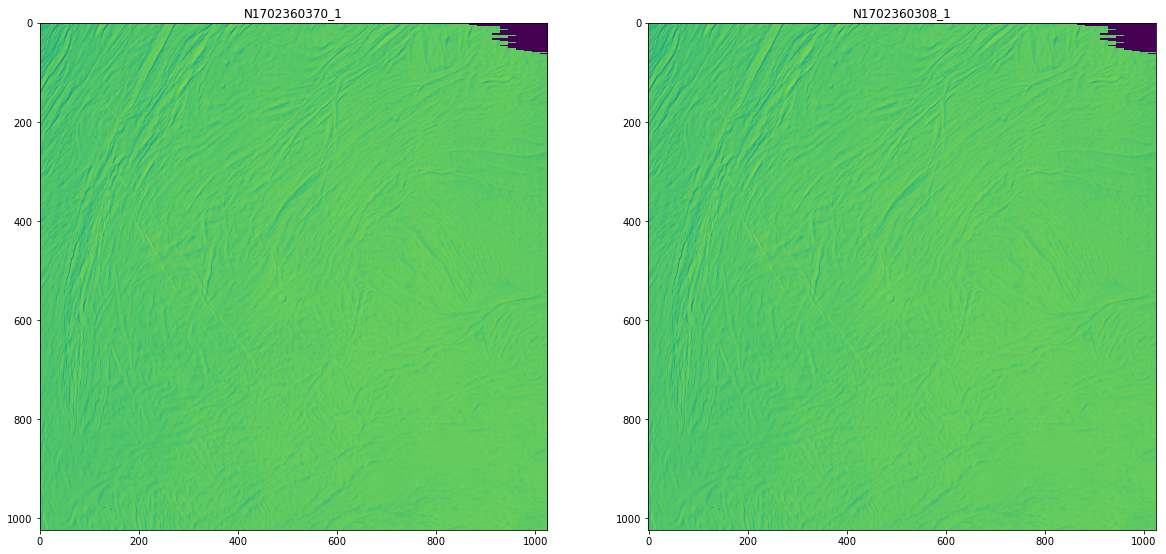

In [5]:
# View the unprojected images

# Open with gdal
nac_stereo_1_data = gdal.Open(nac_stereo_1)
nac_stereo_2_data = gdal.Open(nac_stereo_1)

# Plot
plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 2, 1)
plt.imshow(nac_stereo_1_data.ReadAsArray())
plt.title("N1702360370_1")
ax = plt.subplot(1, 2, 2)
plt.imshow(nac_stereo_2_data.ReadAsArray())
plt.title("N1702360308_1")

Text(0.5, 1.0, 'N1702360308_1')

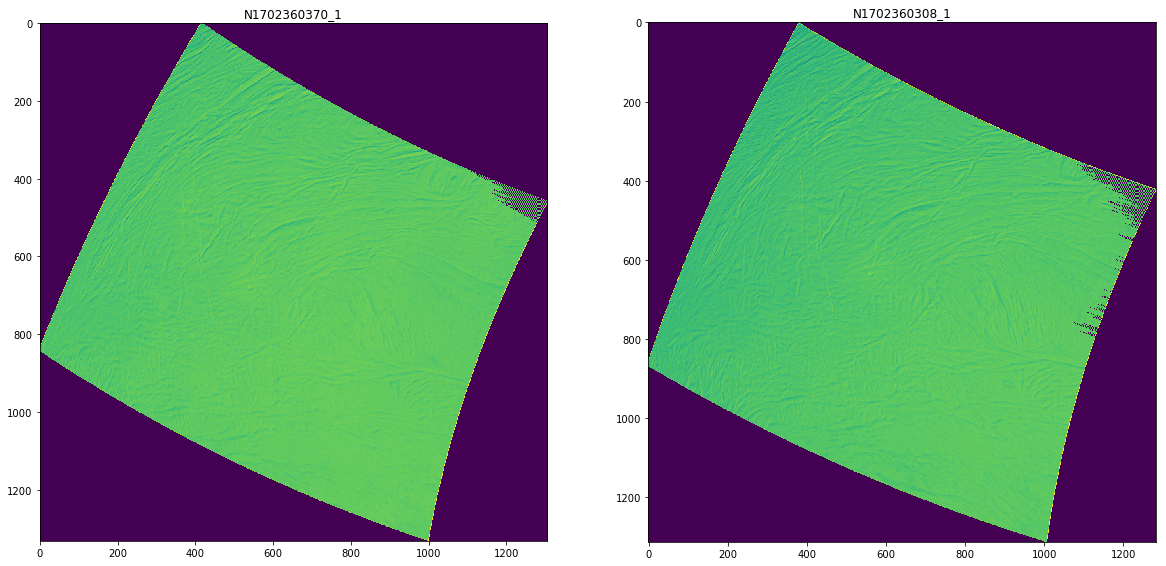

In [6]:
# Project images and view

nac_1_gcps = csm.generate_gcps(camera1, boundary1)
nac_2_gcps = csm.generate_gcps(camera2, boundary2)

proj_str = '+proj=longlat +a={} +b={} +no_defs'.format(nac1_dict['radii']['semimajor'], nac1_dict['radii']['semiminor'])
nac_1_vrt = csm.generate_vrt([n1lines, n1samples], nac_1_gcps, nac_stereo_1, proj_str)
nac_2_vrt = csm.generate_vrt([n2lines, n2samples], nac_2_gcps, nac_stereo_2, proj_str)

warp_options = gdal.WarpOptions(format='VRT', dstNodata=0)
nac_1_lvl2 = 'nac1_lvl2.tif'
nac_2_lvl2 = 'nac2_lvl2.tif'

nac_1_lvl2_data = gdal.Warp(nac_1_lvl2, nac_1_vrt, options=warp_options)
nac_2_lvl2_data = gdal.Warp(nac_2_lvl2, nac_2_vrt, options=warp_options)

plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 2, 1)
plt.imshow(nac_1_lvl2_data.ReadAsArray())
plt.title("N1702360370_1")
ax = plt.subplot(1, 2, 2)
plt.imshow(nac_2_lvl2_data.ReadAsArray())
plt.title("N1702360308_1")